Import relevant packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

tf.enable_eager_execution()
#tf.compat.v1.set_random_seed(18)

/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Set up data loading functions.

In [2]:
tf.__version__

'1.14.0'

In [7]:
# One shot learning - Each network takes input and output and tries to compare if two tasks are the same.
Xt = []
Yt = []
Xv = []
Yv = []

rng = np.random.default_rng()

def load(name):
    with open(name) as json_file:
        data = json.load(json_file) 
        ctraintask = []
        cvaltask = []
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cX = np.concatenate((cinr, coutr))
            if not i == l:
                ctraintask.append(cX)
                Yt.append(name)
            else:
                cvaltask.append(cX)
                Yv.append(name)
        Xt.append(np.array(ctraintask))
        Xv.append(np.array(cvaltask))

def testAccuracy(model, N, loops):
    right = 0
    wrong = 0
    for _ in range(loops):
        basecategory = random.randint(0, Xv.shape[0]-1)
        baseTask = Xv[basecategory][0].reshape(60, 30, 1)
        baseProb = model.predict([np.array([baseTask]), np.array([Xt[basecategory][random.randint(0, Xt[basecategory].shape[0]-1)].reshape(60, 30, 1)])])[0][0]
        for i in range(0, N):
            ccategory = (basecategory+random.randint(1, Xt.shape[0]))%Xt.shape[0]
            cindex = random.randint(0, Xt[ccategory].shape[0]-1)
            ctask = Xt[ccategory][cindex] 
            cProb = model.predict([np.array([baseTask]), np.array([ctask.reshape(60, 30, 1)])])
            if cProb[0][0] > baseProb:
                wrong += 1
                break
        else:
            right += 1
    return (100*right)/loops

def getBatch(batchsize, training):
    if training:
        X = Xt
        Y = Yt
    else:
        X = Xv
        Y = Yv
    categories = rng.choice(X.shape[0], size=(batchsize,), replace=False)
    targets = np.zeros((batchsize,))
    targets[batchsize//2:] = 1
    pairs=[np.zeros((batchsize, 60, 30, 1)) for i in range(2)]
    for i in range(batchsize):
        category = categories[i]
        pairs[0][i,:,:,:] = X[category][random.randint(0, X[category].shape[0]-1)].reshape(60, 30, 1)
        if i >= batchsize // 2:
            category_2 = category
        else:
            category_2 = (category + random.randint(1, X.shape[0])) % X.shape[0] 
        pairs[1][i,:,:,:] = X[category_2][random.randint(0, X[category_2].shape[0]-1)].reshape(60, 30, 1)
    return pairs, targets

def generate(batchsize, training):
    while True:
        pairs, targets = getBatch(batchsize, training)
        yield (pairs, targets)

Load data.

In [9]:
with os.scandir('training/') as entries:
    for entry in entries:
        load("training/"+entry.name)

with os.scandir('test/') as entries:
    for entry in entries:
        load("test/"+entry.name)

Xt = np.array(Xt)
Xv = np.array(Xv)
Yt = np.array(Yt)
Yv = np.array(Yv)

Define model.

In [10]:
# This function is based off the example in this tutorial: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
def get_siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (10,10), padding="same", activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), padding="same", activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), padding="same", activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))

    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    return siamese_net

Train model.

In [11]:
model = get_siamese_model((60, 30, 1))
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)
print(testAccuracy(model, 10, 18))

def trainmodel(epo):
    bestAccuracy = 0

    for i in range(epo):
        model.fit_generator(generate(128, True), epochs=1, steps_per_epoch=50)
        accuracy = testAccuracy(model, 20, 18)
        if accuracy > bestAccuracy:
            model.save_weights("bestCheckpoint/best")
            bestAccuracy = accuracy
            print("New Best: "+str(bestAccuracy))

trainmodel(100)

0.0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
50/50 [==============================] - 11s 227ms/step - loss: 0.5585
New Best: 33.333333333333336
50/50 [==============================] - 10s 198ms/step - loss: 0.4753
New Best: 38.888888888888886
50/50 [==============================] - 10s 198ms/step - loss: 0.4441
New Best: 44.44444444444444
50/50 [==============================] - 10s 198ms/step - loss: 0.4172
New Best: 50.0
50/50 [==============================] - 10s 198ms/step - loss: 0.3940
New Best: 55.55555555555556
50/50 [==============================] - 10s 199ms/step - loss: 0.3279
New Best: 61.111111111111114
50/50 [==============================] - 10s 199ms/step - loss: 0.3222
New Best: 66.66666666666667
50/50 [==============================] - 10s 199ms/step - loss: 0.2884
New Best: 72.22222222222223
50/50 [==============================] - 10s 199ms/step - loss: 0.2660
New Best: 77.77777777777777
50/50 [==============

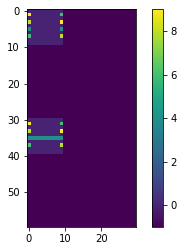

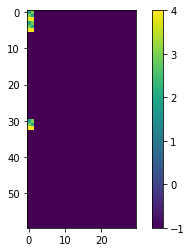

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


In [19]:
n = 12
k = 10
ctask1 = Xt[n][0].reshape(60, 30, 1)
plt.imshow(ctask1.reshape(60, 30))
plt.colorbar()
plt.show()
ctask2 = Xv[k][0].reshape(60, 30, 1)
plt.imshow(ctask2.reshape(60, 30))
plt.colorbar()
plt.show()
taskin = []
taskin.append(tf.convert_to_tensor(np.array([ctask1.astype(np.float32)])))
taskin.append(tf.convert_to_tensor(np.array([ctask2.astype(np.float32)])))

print(model(taskin))

Adversarial Generation.

In [25]:
import matplotlib.pyplot as plt
model = get_siamese_model((60, 30, 1))
model.load_weights("bestCheckpoint/best")

In [182]:
#sampletask = [np.array([AI.Xt[0][0].reshape(60,30,1)]), np.array([AI.Xt[1][1].reshape(60,30,1)])]
loss_object = tf.keras.losses.BinaryCrossentropy()
def getGradients(taskin):
    taskin[0] = tf.convert_to_tensor(taskin[0].astype(np.float32))
    taskin[1] = tf.convert_to_tensor(taskin[1].astype(np.float32))
    with tf.GradientTape() as tape:
        tape.watch(taskin)
        prediction = model(taskin)
        loss = loss_object(tf.convert_to_tensor(np.array([1]).reshape(1, 1)), prediction)
    gradient = tape.gradient(loss, taskin)
    #signs = tf.sign(gradient)
    return [gradient[1].numpy()[0][30:], loss, prediction]

def generateTask(examples, cin, l, accthresh, verbose):
    cin = cin.astype(np.float64)
    lasterr = 99999
    for i in range(1000):
        grads = np.zeros((30, 30, 1))
        err = 0
        acc = 0
        for e in examples:
            sampletask = [np.array([e]), np.array([cin.reshape(60,30,1)])]
            result = getGradients(sampletask)
            grads += result[0]
            err += result[1].numpy()
            acc += result[2].numpy()[0][0]
        grads /= len(examples)
        err /= len(examples)
        acc /= len(examples)
        grads *= l
        adjustment = np.zeros((60,30,1))
        adjustment[30:, :, :] = grads
        cin -= adjustment
        np.clip(cin, -1, 9, out=cin)
        if verbose:
            if i%100 == 0:
                print("EPOCH "+str(i)+": "+str(err)+" "+str(acc))
            if i%500 == 0:
                out = cin.reshape(60, 30)[30:, :]
                plt.imshow(out)
                plt.colorbar()
                plt.show()
        if acc*100 > accthresh:
            if verbose:
                print("STOPPING AT "+str(err))
            break
    out = cin.reshape(60, 30)[30:, :]
    return out

def generateExample(taskclass, thresh):
    examples = []
    for i in range(Xt[taskclass].shape[0]):
        examples.append(Xt[taskclass][i].reshape(60,30,1).astype(np.float64))
    cin = np.array([Xv[taskclass][0].reshape(60,30,1)])
    cin[0][30:, :, :] = cin[0][:30, :, :]
    out = generateTask(examples, cin, 0.5, thresh, False)
    cout = cin[0].reshape(60, 30)
    cout[30:, :] = out
    return cout

In [201]:
from timeit import default_timer as timer
import random

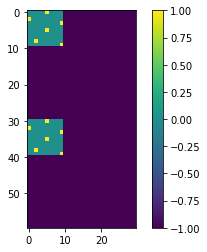

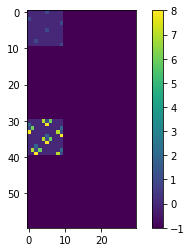

In [209]:
cclass = random.randint(0, Xt.shape[0])
out = generateExample(cclass, 80)
correct = Xv[cclass][0]
plt.imshow(out)
plt.colorbar()
plt.show()
plt.imshow(correct)
plt.colorbar()
plt.show()

In [ ]:
Xadv = []
Yadv = []
for i in range(Xt.shape[0]):

500
2


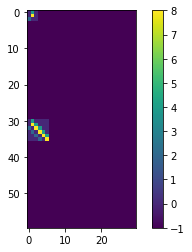

In [188]:
print(Xt.shape[0])
n = 170
print(len(Xt[n]))
plt.imshow(Xt[n][1].reshape(60, 30))
plt.colorbar()
plt.show()

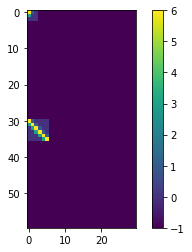

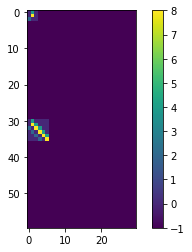

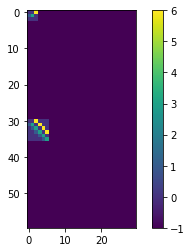

In [189]:
plt.imshow(Xt[n][0].reshape(60, 30))
plt.colorbar()
plt.show()
plt.imshow(Xt[n][1].reshape(60, 30))
plt.colorbar()
plt.show()
plt.imshow(Xv[n][0].reshape(60, 30))
plt.colorbar()
plt.show()
examples = [Xt[n][0].reshape(60,30,1).astype(np.float64), Xt[n][1].reshape(60,30,1).astype(np.float64)] 
cin = np.array([Xv[n][0].reshape(60,30,1)])
cin[0][30:, :, :] = cin[0][:30, :, :]
#cin[0][30:, :, :] = np.random.randint(-1, 10, size=(30, 30, 1))
#cin[0][30:, :, :] = np.zeros((30, 30, 1))
#sampletask[1][0][30:, :, :] = np.random.randint(-1, 11, size=(30, 30, 1))
#plt.imshow(cin.reshape(60, 30))
#plt.colorbar()
#plt.show()
#out = generateTask(examples, cin, 10, 40000)
#plt.imshow(out)
#plt.colorbar()
#plt.show()